In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import random
def plot_word2vec_embeddings(model, num_words=100):
    words = list(model.wv.index_to_key)[:num_words]
    vectors = np.array([model.wv[word] for word in words])
    
    # Compute cosine similarity matrix
    cosine_sim = cosine_similarity(vectors)
    
    # Create a graph from the cosine similarity matrix
    G = nx.from_numpy_array(cosine_sim)
    
    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    plt.title('Word2Vec Embeddings Visualization')
    plt.axis('off')
    plt.show()

In [29]:
articles = pd.read_csv('/Users/macintosh/Desktop/Vaccination/articles.csv')


In [30]:

product = pd.read_csv('/Users/macintosh/Desktop/Vaccination/CARS_1.csv')


In [31]:
GraphTravel_HM = product.rename(columns={'reviews_count': 't_dat', 'car_name': 'customer_id', 'fuel_tank_capacity': 'article_id', 'engine_displacement': 'frequency'})
GraphTravel_HM




,customer_id,t_dat,fuel_type,frequency,no_cylinder,seating_capacity,transmission_type,article_id,body_type,rating,starting_price,ending_price,max_torque_nm,max_torque_rpm,max_power_bhp,max_power_rp
0,Maruti Alto K10,51,Petrol,998,3,5.0,Automatic,27.0,Hatchback,4.5,399000,583000,89.0,3500,65.71,5500
1,Maruti Brezza,86,Petrol,1462,4,5.0,Automatic,48.0,SUV,4.5,799000,1396000,136.8,4400,101.65,6000
2,Mahindra Thar,242,Diesel,2184,4,4.0,Automatic,57.0,SUV,4.5,1353000,1603000,300.0,2800,130.00,3750
3,Mahindra XUV700,313,Diesel,2198,4,7.0,Automatic,60.0,SUV,4.5,1318000,2458000,450.0,2800,182.38,3500
4,Mahindra Scorpio-N,107,Diesel,2198,4,7.0,Automatic,57.0,SUV,4.5,1199000,2390000,400.0,2750,172.45,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Mercedes-Benz AMG A 45 S,35,Petrol,1991,4,5.0,Automatic,0.0,Hatchback,4.5,659000,999000,500.0,5250,415.71,6750
199,BMW 3 Series Gran Limousine,3,Petrol,1998,4,5.0,Automatic,59.0,Sedan,4.5,1041000,1041000,400.0,4400,254.79,5000
200,MG Hector Plus,2,Diesel,1956,4,7.0,Manual,60.0,SUV,4.5,1615000,2075000,350.0,2500,167.67,3750
201,Audi RS Q8,9,Petrol,3998,8,5.0,Automatic,85.0,SUV,3.5,21700000,21700000,800.0,4500,591.39,6000


In [32]:
unique_customer_ids = GraphTravel_HM['customer_id'].unique()
customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))  # BEGIN: Mapping articles to product names


In [33]:
G = nx.Graph()

for index, row in GraphTravel_HM.iterrows():
    G.add_node(row['customer_id'], type='user')
    G.add_node(row['article_id'], type='item')
    G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])


In [34]:
# BEGIN: Biased Random Walk Function
def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter 
                        probability.append(1/p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter 
                        probability.append(1)
                    else:
                        # In-out parameter 
                        probability.append(1/q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk
# END: Biased Random Walk Function


In [35]:
# BEGIN: Generate Walks Function
def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # to ensure randomness
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks
# END: Generate Walks Function


In [36]:
GraphTravel_HM = GraphTravel_HM.dropna(subset=['customer_id', 'article_id'])

# Ensure no NaN values in the graph
G = nx.Graph()
for index, row in GraphTravel_HM.iterrows():
    if pd.notna(row['customer_id']) and pd.notna(row['article_id']):  # Check for NaN
        G.add_node(row['customer_id'], type='user')
        G.add_node(row['article_id'], type='item')
        G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

# Random Walk 
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)
filtered_walks = [walk for walk in walks if len(walk) >= 5]

# to String  (for Word2Vec input)
walks = [[str(node) for node in walk] for walk in walks]

# Word2Vec train
model = Word2Vec(walks, vector_size=128, window=5, min_count=0,  hs=1, sg=1, workers=4, epochs=10)

# node embedding extract
embeddings = {node_id: model.wv[node_id] for node_id in model.wv.index_to_key}


In [37]:
def get_user_embedding(user_id, embeddings):
    return embeddings[str(user_id)]


In [38]:
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])


In [39]:
def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = get_user_embedding(user_id, embeddings)

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items:  
            item_embedding = embeddings[str(item_id)]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities


In [40]:
# BEGIN: Function to Show Images
def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20,10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity}")
        else:
            print()
        img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()
# END: Function to Show Images


In [41]:
def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    rated_items = get_rated_items(user_id, df)
    
    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))
    
    item_similarities = calculate_similarities(user_id, df, embeddings)

    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


In [44]:
GraphTravel_HM

,customer_id,t_dat,fuel_type,frequency,no_cylinder,seating_capacity,transmission_type,article_id,body_type,rating,starting_price,ending_price,max_torque_nm,max_torque_rpm,max_power_bhp,max_power_rp
0,0,51,Petrol,998,3,5.0,Automatic,27.0,Hatchback,4.5,399000,583000,89.0,3500,65.71,5500
1,1,86,Petrol,1462,4,5.0,Automatic,48.0,SUV,4.5,799000,1396000,136.8,4400,101.65,6000
2,2,242,Diesel,2184,4,4.0,Automatic,57.0,SUV,4.5,1353000,1603000,300.0,2800,130.00,3750
3,3,313,Diesel,2198,4,7.0,Automatic,60.0,SUV,4.5,1318000,2458000,450.0,2800,182.38,3500
4,4,107,Diesel,2198,4,7.0,Automatic,57.0,SUV,4.5,1199000,2390000,400.0,2750,172.45,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,195,35,Petrol,1991,4,5.0,Automatic,0.0,Hatchback,4.5,659000,999000,500.0,5250,415.71,6750
199,85,3,Petrol,1998,4,5.0,Automatic,59.0,Sedan,4.5,1041000,1041000,400.0,4400,254.79,5000
200,196,2,Diesel,1956,4,7.0,Manual,60.0,SUV,4.5,1615000,2075000,350.0,2500,167.67,3750
201,197,9,Petrol,3998,8,5.0,Automatic,85.0,SUV,3.5,21700000,21700000,800.0,4500,591.39,6000


In [47]:
# Check if the item ID exists in the mapping before accessing it
def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20,10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        if item_id in item_name_mapping:  # BEGIN: Check for item ID existence
            print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
            if show_similarity:
                print(f" with similarity score: {similarity}")
            else:
                print()
            img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
            try:
                img = mpimg.imread(img_path)
                ax[i].imshow(img)
                ax[i].set_title(f'Item {item_id}')
                ax[i].set_xticks([], [])
                ax[i].set_yticks([], [])
                ax[i].grid(False)
            except FileNotFoundError:
                print(f"Image for item {item_id} not found.")
        else:
            print(f"Item ID {item_id} not found in item_name_mapping.")  # END: Check for item ID existence
    plt.show()


In [50]:
# Ensure df is defined before this cell
df = pd.read_csv('/Users/macintosh/Desktop/Vaccination/articles.csv')  # Adjust the path as necessary


User 1 has purchased:
Item ID 48.0 not found in item_name_mapping.


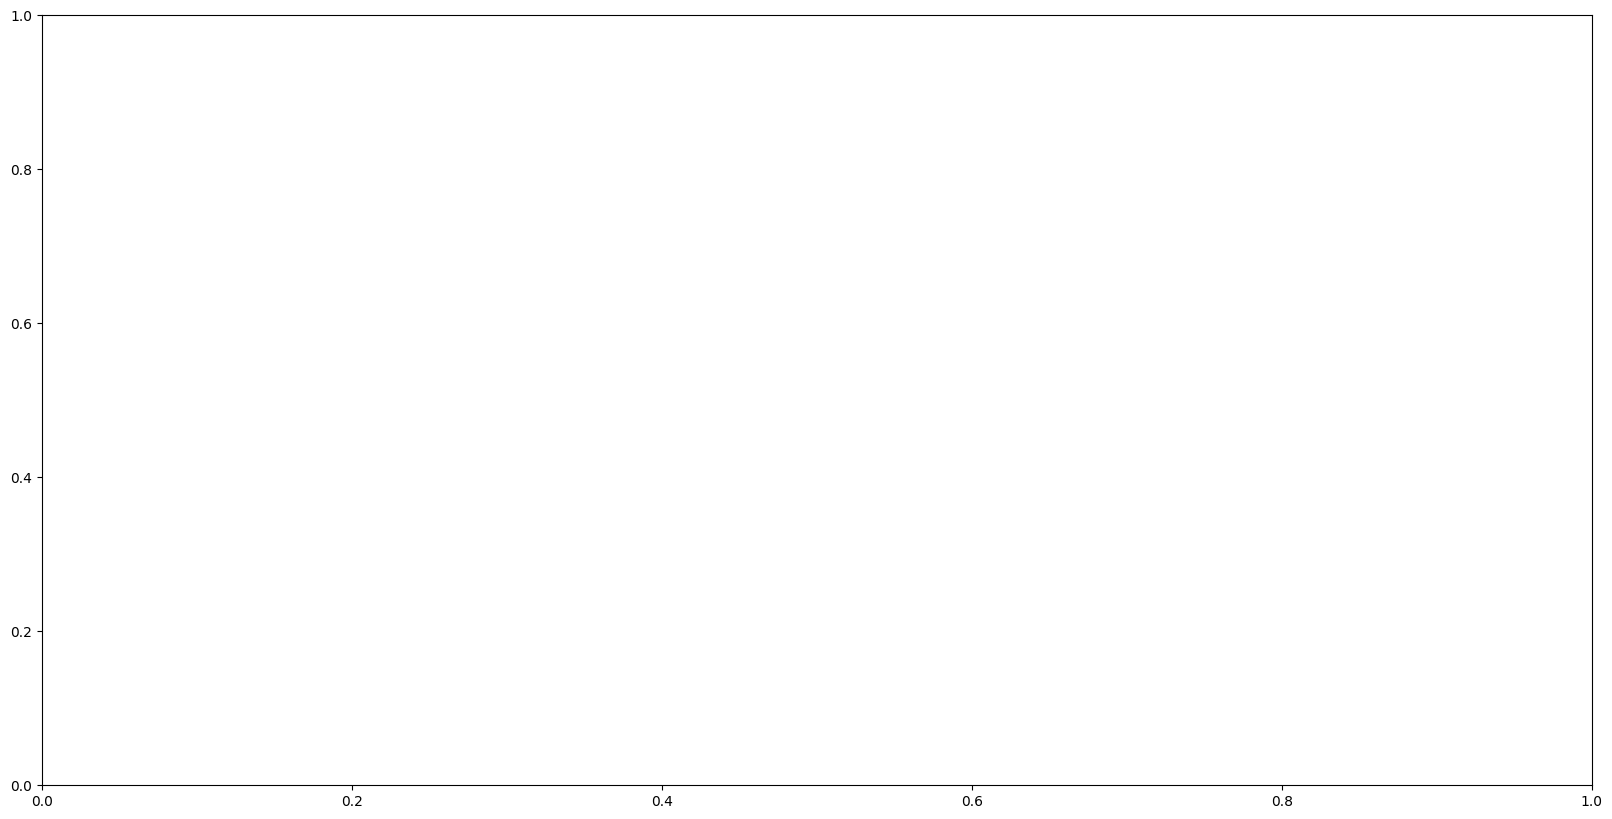


Recommended items for user 1:
Item ID 32.0 not found in item_name_mapping.
Item ID 40.0 not found in item_name_mapping.
Item ID 30.0 not found in item_name_mapping.
Item ID 43.0 not found in item_name_mapping.
Item ID 45.0 not found in item_name_mapping.


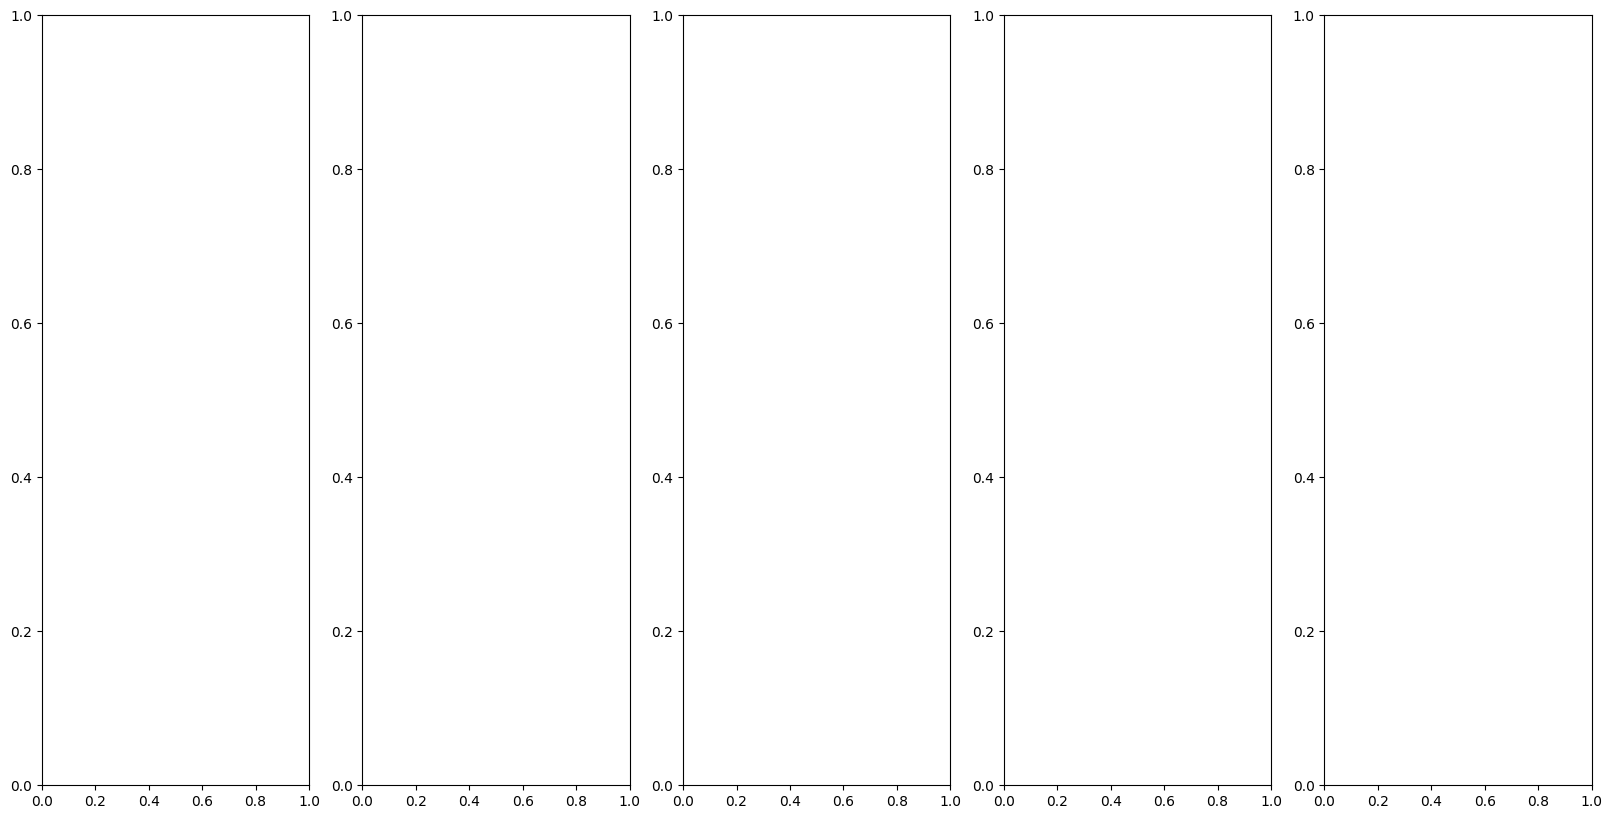

In [54]:
recommend_items(user_id, GraphTravel_HM, embeddings, item_name_mapping, num_items=5)
